In [1]:
import netCDF4 as nc
import numpy as np
netL=[]

with nc.Dataset('wrfout_d02_2010-09-21_10:00:00') as f:
    qr=f['QRAIN'][0,:,:,:]
    qc=f['QCLOUD'][0,:,:,:]
    p=f['P'][0,:,:,:]+f['PB'][0,:,:,:]
    t=f['T'][0,:,:,:]+300
    tk=t*(p/100000)**(287/1004)
    rho_air=p/(287*tk)

with nc.Dataset('auxhist2_d02_2010-09-21_12:00:00') as f:
    for i in range(43):
        netb=f['ffc%2.2idr'%(i+1)][:]
        netL.append(netb[0,:,:,:])

netL=np.array(netL).T

In [2]:
print(netL.shape)
import readsbm
readsbm.set_sdsu_param(43)
q_sbm,n_sbm,dm3d=readsbm.aux2nc_liq(netL,rho_air.T)


(399, 399, 60, 43)


In [16]:
log_n=np.log10(1+n_sbm/1e0)
a=np.nonzero(q_sbm>1e-2)
print(len(a[0])/(399*399*43))

0.33048845813315125


In [35]:
#define a vanilla autoencoder that takes vectors of length 43 and outputs vectors of length 43

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Reshape, Conv2DTranspose, Lambda, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

def sampling(args):  # this is for a VAE. We do not use it here. Instead, we use a vanilla autoencoder
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], 43), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

def encoder():
    input_vec = Input(shape=(43,1))
    x = Conv1D(32, (3), activation='relu', padding='same')(input_vec)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = MaxPooling1D((2), padding='same')(x)
    x = Conv1D(32, (3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = MaxPooling1D((2), padding='same')(x)
    x = Conv1D(32, (3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = MaxPooling1D((2), padding='same')(x)
    x = Conv1D(1, (3), padding='same')(x)
    x = MaxPooling1D((2), padding='same')(x)
    return Model(input_vec, x[:])

encoder_model = encoder()
#print(encoder_model.summary())

In [36]:
from tensorflow.keras.layers import Input, Dense, Conv1DTranspose
def decoder():
    input_=Input(shape=(3,1))
    x = UpSampling1D((2))(input_)
    x = Conv1DTranspose(32, (3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = UpSampling1D((2))(x)
    x = Conv1D(32, (3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = UpSampling1D((2))(x)
    x = Conv1D(32, (3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = UpSampling1D((2))(x)
    x = Conv1D(1, (3), padding='same')(x)
    return Model(input_, x[:,:-5,:])

decoder_model = decoder()
#print(decoder_model.summary())

In [38]:
autoencoder=Model(encoder_model.input, decoder_model(encoder_model.output))


In [45]:
from sklearn.model_selection import train_test_split
log_n_rain=log_n[a]
x_train, x_test, y_train, y_test = train_test_split(log_n_rain[:,:,np.newaxis],log_n_rain[:,:,np.newaxis], test_size=0.2, random_state=42)

autoencoder.compile(optimizer='adam', loss='mse')


In [46]:
print(x_train.shape)

(1809924, 43, 1)


In [62]:
history=autoencoder.fit(x_train, y_train,epochs=1, batch_size=128, shuffle=True, validation_data=(x_test, y_test))



14141/14141 [==============================] - 197s 14ms/step - loss: 0.2914 - val_loss: 0.5925


In [65]:
y2_=autoencoder.predict(x_test)
print(np.corrcoef(y2_.flatten(),y_test.flatten()))
autoencoder.save('autoencoder.h5')

14141/14141 [==============================] - 18s 1ms/step
[[1.         0.98326441]
 [0.98326441 1.        ]]


/Users/mgrecu/miniconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


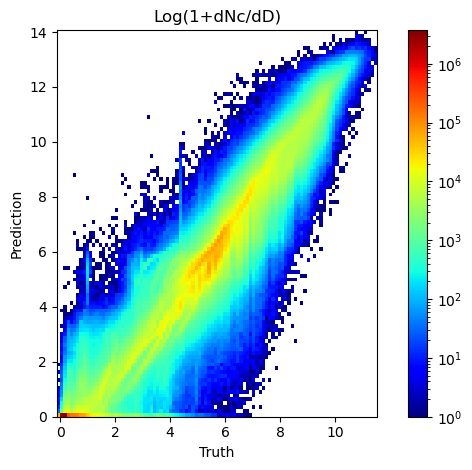

In [68]:
np.corrcoef(y_.flatten(),y_test.flatten())
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
ax=plt.subplot(111)
h2d=plt.hist2d(y2_.flatten(),y_test.flatten(),bins=100,norm=LogNorm(),cmap='jet')
ax.set_aspect('equal')
plt.xlabel('Truth')
plt.ylabel('Prediction')
plt.title('Log(1+dNc/dD)')
plt.tight_layout()
plt.colorbar(h2d[3])
plt.savefig('autoencoderPSD_Results.png',dpi=300)

In [59]:
# import pca from sklearn
from sklearn.decomposition import PCA

#from sklearn import PCA

pca=PCA(n_components=0.95)
pca.fit(x_train[:,:,0])

PCA(n_components=0.95)

In [67]:
print(1-(y2_.flatten()-y_test.flatten()).var()/y_test.flatten().var())

0.9520709291100502


In [60]:
print(pca.explained_variance_ratio_)

[0.81367318 0.06136112 0.04666168 0.02355612 0.01312129]


In [ ]:
from sklearn.decomposition import PCA

# Assuming x_train is the training data
pca = PCA(n_components=0.95)
pca.fit(x_train)

explained_variance_ratio = pca.explained_variance_ratio_


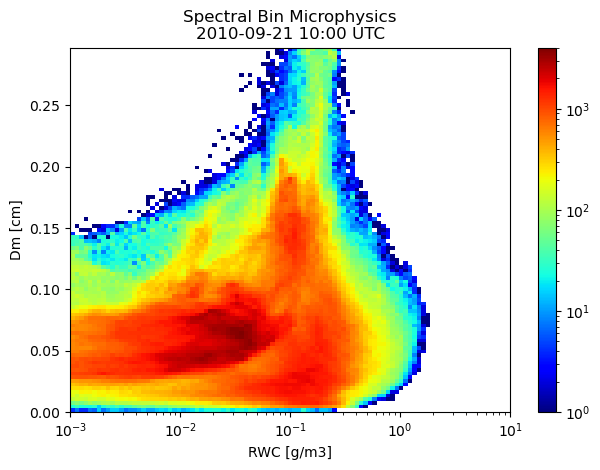

In [7]:
import matplotlib.pyplot as plt
import matplotlib.colors
a=np.nonzero(q_sbm>1e-4)
x1=np.logspace(-3,1,100)
y1=np.arange(100)*0.003
h2d=plt.hist2d(q_sbm[a],dm3d[a],bins=(x1,y1),norm=matplotlib.colors.LogNorm(),cmap='jet')
plt.xscale('log')
plt.colorbar(h2d[3])
plt.xlabel('RWC [g/m3]')
plt.ylabel('Dm [cm]')
plt.title('Spectral Bin Microphysics\n2010-09-21 10:00 UTC') 
plt.tight_layout()
plt.savefig('sbm_0921_12:00.png',dpi=300)

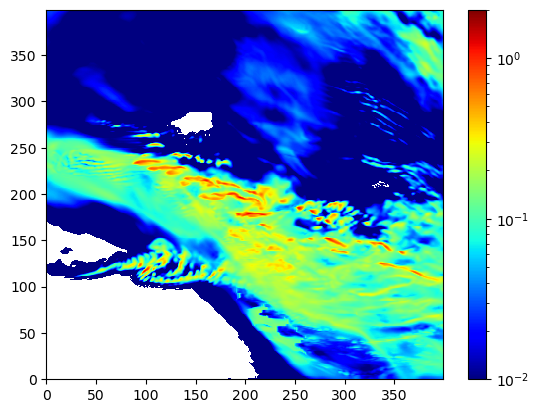

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors

plt.pcolormesh(q_sbm[:,:,0],cmap='jet',norm=matplotlib.colors.LogNorm(vmin=1e-2,vmax=2e0))
plt.colorbar()